## Setup

In [1]:
import os
import sys

from crosscoder.utils import *
from crosscoder.crosscoder import CrossCoder
from collections import defaultdict

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from transformers import AutoTokenizer

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils import *

torch.set_grad_enabled(False);

device = "cuda:0"

/data2/hluo/anaconda3/envs/xllm/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning:

Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.

2025-03-09 00:44:42.055665: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-09 00:44:42.055719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-09 00:44:42.057424: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-09 00:44:42.065966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instruction

## Case study on bias: Stereoset

In [2]:
dataset = load_stereoset(type="dev")

# We are interested in four bias types:
bias_types_of_interest = {"gender", "profession", "race", "religion"}
bias_groups = defaultdict(list)
for item in dataset:
    if item['label'] in ['unrelated']:
        continue
    if item["bias_type"] in bias_types_of_interest:
        bias_groups[item["bias_type"]].append(item)

# For further processing, build lists for texts and corresponding metadata.
all_texts = []
metadata = []  # each entry: dict with keys: bias_type, target
for bias in bias_types_of_interest:
    for item in bias_groups[bias]:
        all_texts.append(item["input"])
        metadata.append({"bias_type": item["bias_type"], "target": item["target"]})


In [3]:
# get the indices of the unrelated sentences
unrelated_indices = [i for i, d in enumerate(dataset) if d['label'] == 'unrelated']

# we only want to keep the sentences related to stereotypes or anti-stereotypes
X_bias = np.load(f"/data2/hluo/dataset/stereoset/Qwen2-1.5B/X_24_resid_pre_latercontext.npy") 
X_bias = np.delete(X_bias, unrelated_indices, axis=0)
y_bias = construct_y(dataset, get_unrelated_for_detector=False)
y_bias = np.delete(y_bias, unrelated_indices)

### Get bias probes and indices for crosscoders

In [4]:
bias_probes, bias_operator = compute_variance_based_projection_matrix(X_bias, y_bias, top_k_singular=4)

In [5]:
sys.path.append('/data2/hluo/checkpoints/crosscoders')  # path to trained crosscoders

crosscoder_layers = CrossCoder.load(
    "version_0",
    checkpoint_version=0, 
    save_dir="/data2/hluo/checkpoints/crosscoders/qwen_layer_14_24"
)
crosscoder_layers.to(device)
crosscoder_layers.eval()

{'batch_size': 2048,
 'beta1': 0.9,
 'beta2': 0.999,
 'buffer_mult': 128,
 'd_in': 1536,
 'dec_init_norm': 0.08,
 'device': 'cuda:0',
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'hook_point': 'hook_resid_pre',
 'l1_coeff': 2,
 'layer_length': [14, 24],
 'log_every': 20,
 'lr': 5e-05,
 'model_batch_size': 16,
 'model_name': 'qwen',
 'num_tokens': 25000000,
 'save_dir': '/data2/hluo/checkpoints/crosscoders/qwen_layer_14_24',
 'save_every': 30000,
 'seed': 49,
 'seq_len': 256,
 'site': 'resid_pre',
 'wandb_project': 'crosscoder',
 'wandb_run_name': 'qwen_multi_layer'}


CrossCoder()

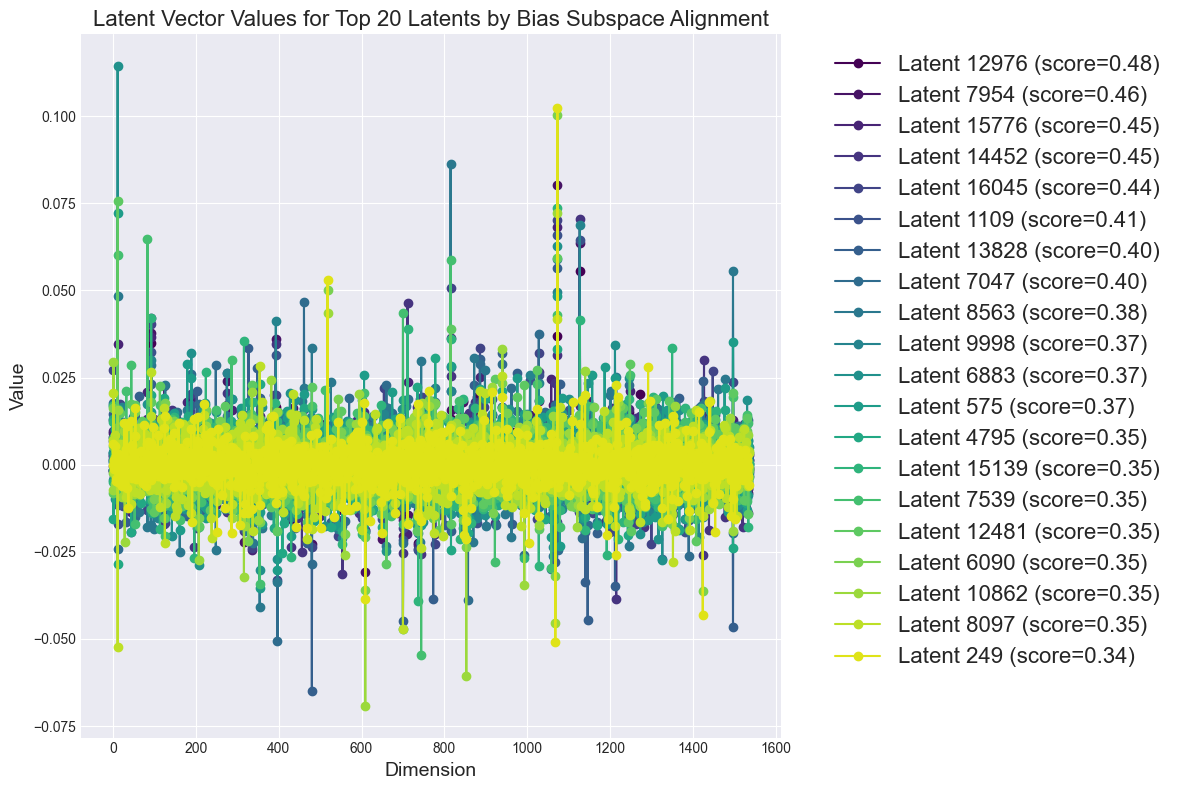

Top latent info (index, score): [(12976, 0.48319405), (7954, 0.45946524), (15776, 0.45426902), (14452, 0.44751814), (16045, 0.44405752), (1109, 0.40837398), (13828, 0.4043729), (7047, 0.4008464), (8563, 0.3757659), (9998, 0.37365443), (6883, 0.371468), (575, 0.36991978), (4795, 0.35467014), (15139, 0.35044402), (7539, 0.35023442), (12481, 0.34957916), (6090, 0.34774324), (10862, 0.34752133), (8097, 0.34511065), (249, 0.34496874)]


In [6]:
fig_dir = "figs"
os.makedirs(fig_dir, exist_ok=True)

num_top_latents = 20

bias_probes_matrix = torch.tensor(bias_probes, dtype=torch.float32).to(device)
bias_probes_matrix = bias_probes_matrix / bias_probes_matrix.norm(dim=0, keepdim=True)

latent_vectors = crosscoder_layers.W_dec.mean(dim=1)  # shape: [num_latents, d_in]
latent_vectors_norm = latent_vectors / latent_vectors.norm(dim=-1, keepdim=True)

proj_coeffs = latent_vectors_norm @ bias_probes_matrix  # shape: [num_latents, num_probes]
alignment_scores = torch.linalg.norm(proj_coeffs, dim=1)  # shape: [num_latents]
alignment_scores_np = alignment_scores.cpu().numpy()

top_indices = np.argsort(alignment_scores_np)[-num_top_latents:][::-1]

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(12, 8))
cmap = plt.get_cmap("viridis")
colors = [cmap(i / num_top_latents) for i in range(num_top_latents)]

top_info = []
for i, idx in enumerate(top_indices):
    latent_vector = latent_vectors[idx].detach().cpu().numpy()  # shape: [d_in]
    score = alignment_scores_np[idx]
    top_info.append((idx, score))
    plt.plot(
        latent_vector,
        marker='o',
        linestyle='-',
        color=colors[i],
        label=f'Latent {idx} (score={score:.2f})'
    )

plt.xlabel("Dimension", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.title(f"Latent Vector Values for Top {num_top_latents} Latents by Bias Subspace Alignment", fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=16)
plt.grid(True)
plt.tight_layout()

save_path = os.path.join(fig_dir, "top_latents_base.png")
plt.savefig(save_path, dpi=300)
plt.show()

print("Top latent info (index, score):", top_info)

### Cache activations on Stereoset

In [7]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2-1.5B")
model = HookedTransformer.from_pretrained(
    "Qwen/Qwen2-1.5B",
    device=device, 
    dtype=torch.bfloat16
)
model.to(device)
model.eval()

Loaded pretrained model Qwen/Qwen2-1.5B into HookedTransformer
Moving model to device:  cuda:0


HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (blocks): ModuleList(
    (0-27): 28 x TransformerBlock(
      (ln1): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): RMSNormPre(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): GroupedQueryAttention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
        (hook_rot_k): HookPoint()
        (hook_rot_q): HookPoint()
      )
      (mlp): GatedMLP(
        (hook_pre): HookPoint()
        (hook_pre_linear): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_att

In [8]:
encoded = tokenizer(all_texts, return_tensors="pt", padding=True, truncation=True)
for key in encoded:
    encoded[key] = encoded[key].to(device)

In [9]:
layer_start = 14
layer_end = 24 
hook_point_name = "hook_resid_pre"
hook_points = [f"blocks.{layer}.{hook_point_name}" for layer in range(layer_start, layer_end)]

batch_size = 128  # due to my cuda memory constraints
num_batches = (encoded["input_ids"].shape[0] + batch_size - 1) // batch_size

cache = {}
with torch.no_grad():
    for i in tqdm(range(num_batches)):
        batch_input_ids = encoded["input_ids"][i * batch_size:(i + 1) * batch_size]
        _, batch_cache = model.run_with_cache(batch_input_ids, names_filter=hook_points, return_type=None)
        
        for key in batch_cache:
            if key not in cache:
                cache[key] = batch_cache[key]
            else:
                cache[key] = torch.cat((cache[key], batch_cache[key]), dim=0)

import gc
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 34/34 [00:11<00:00,  3.00it/s]


### Activations for bias-related latents

In [10]:
# -----------------------------------------------------------------------------
# For each layer, we use the corresponding encoder weight from crosscoder_layers.
# For each example, we average the latent projection over tokens (ignore bos)
# We then store the latent feature (index 0) for each example grouped by bias_type and target.
# -----------------------------------------------------------------------------

# results[bias_type][target][layer] will hold a list of latent feature values (averaged per example)
results = {bias: {0: {layer: [] for layer in range(layer_start, layer_end)},
                  1: {layer: [] for layer in range(layer_start, layer_end)}
                  } for bias in bias_types_of_interest}

with torch.no_grad():
    for i, layer in enumerate(range(layer_start, layer_end)):
        hook_name = f"blocks.{layer}.{hook_point_name}"
        activation = cache[hook_name]  # shape [B, T, d_in]
        activation = activation[:, 1:, :]  # ignore bos token
        B, T, d_in = activation.shape

        activation = activation.reshape(-1, d_in)  # shape [B*T, d_in]
        W_enc_bf16 = crosscoder_layers.W_enc[i].to(torch.bfloat16)  # shape [d_in, d_hidden]
        b_enc_bf16 = crosscoder_layers.b_enc.to(torch.bfloat16)
        latent = F.relu(activation @ W_enc_bf16 + b_enc_bf16)  # shape [B*T, d_hidden]

        latent_feature = latent[:, list(top_indices)].mean(dim=-1)  # shape [B*T]
        # latent_feature = latent[:, list(random_indices)].mean(dim=-1)  # shape [B*T]
        
        latent_feature_avg = latent_feature.reshape(B, T).mean(dim=1)  # shape [B]
        latent_feature_avg = latent_feature_avg.float()
        
        # Store latent feature for each example according to its metadata.
        for j, meta in enumerate(metadata):
            results[meta["bias_type"]][meta["target"]][layer].append(latent_feature_avg[j].item())

torch.cuda.empty_cache()

In [11]:
# create random indices for random latent feature extraction
random_indices = np.random.choice(2**14, 2000, replace=False)  # ensure randomness, use 2k

random_results = {bias: {0: {layer: [] for layer in range(layer_start, layer_end)},
                  1: {layer: [] for layer in range(layer_start, layer_end)}
                  } for bias in bias_types_of_interest}

with torch.no_grad():
    for i, layer in enumerate(range(layer_start, layer_end)):
        hook_name = f"blocks.{layer}.{hook_point_name}"
        activation = cache[hook_name]  # shape [B, T, d_in]
        activation = activation[:, 1:, :]  # ignore bos token
        B, T, d_in = activation.shape

        activation = activation.reshape(-1, d_in)  # shape [B*T, d_in]
        W_enc_bf16 = crosscoder_layers.W_enc[i].to(torch.bfloat16)  # shape [d_in, d_hidden]
        b_enc_bf16 = crosscoder_layers.b_enc.to(torch.bfloat16)
        latent = F.relu(activation @ W_enc_bf16 + b_enc_bf16)  # shape [B*T, d_hidden]

        latent_feature = latent[:, list(random_indices)].mean(dim=-1)  # shape [B*T]
        
        latent_feature_avg = latent_feature.reshape(B, T).mean(dim=1)  # shape [B]
        latent_feature_avg = latent_feature_avg.float()
        
        # Store latent feature for each example according to its metadata.
        for j, meta in enumerate(metadata):
            random_results[meta["bias_type"]][meta["target"]][layer].append(latent_feature_avg[j].item())

torch.cuda.empty_cache()

In [14]:
# load the pickle of results for it model
import pickle
with open("results/results_it.pickle", "rb") as f:
    results_it = pickle.load(f)

In [25]:
sorted(bias_types_of_interest)

['gender', 'profession', 'race', 'religion']

In [ ]:
from plotly.subplots import make_subplots
import numpy as np
import plotly.graph_objects as go

bias_list = sorted(bias_types_of_interest)
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=bias_list,
    shared_xaxes=True, shared_yaxes=True
)

for i, bias in enumerate(bias_list):
    layers = list(range(layer_start, layer_end))
    # Base model results
    base_m0, base_m1 = [], []
    base_std0, base_std1 = [], []
    # Instruction-tuned results
    it_m0, it_m1 = [], []
    it_std0, it_std1 = [], []
    # Random results averaged across targets
    random_m = []

    for layer in layers:
        # Base
        values0 = results[bias][0][layer]
        values1 = results[bias][1][layer]
        m0 = np.mean(values0) if len(values0) > 0 else 0
        m1 = np.mean(values1) if len(values1) > 0 else 0
        s0 = np.std(values0) if len(values0) > 0 else 0
        s1 = np.std(values1) if len(values1) > 0 else 0
        base_m0.append(m0)
        base_m1.append(m1)
        base_std0.append(s0)
        base_std1.append(s1)
        
        # Instruction tuned
        it_values0 = results_it[bias][0][layer]
        it_values1 = results_it[bias][1][layer]
        m0_it = np.mean(it_values0) if len(it_values0) > 0 else 0
        m1_it = np.mean(it_values1) if len(it_values1) > 0 else 0
        s0_it = np.std(it_values0) if len(it_values0) > 0 else 0
        s1_it = np.std(it_values1) if len(it_values1) > 0 else 0
        it_m0.append(m0_it)
        it_m1.append(m1_it)
        it_std0.append(s0_it)
        it_std1.append(s1_it)
        
        # Random: average of both targets
        rand0 = np.mean(random_results[bias][0][layer]) if len(random_results[bias][0][layer]) > 0 else 0
        rand1 = np.mean(random_results[bias][1][layer]) if len(random_results[bias][1][layer]) > 0 else 0
        random_m.append((rand0 + rand1)/2)
    
    row = i // 2 + 1
    col = i % 2 + 1
    showlegend = True if i == 0 else False

    # BASE model traces in orange
    # Anti-stereotype (Base) in orange solid
    fig.add_trace(go.Scatter(
        x=layers,
        y=base_m0,
        mode='lines+markers',
        name='Anti-stereotype (Base)',
        line=dict(color='orange', dash='solid'),
        showlegend=showlegend
    ), row=row, col=col)
    
    # Shaded area for base anti-stereotype in orange (darker tint)
    upper = np.array(base_m0) + np.array(base_std0)
    lower = np.array(base_m0) - np.array(base_std0)
    fig.add_trace(go.Scatter(
        x=layers + layers[::-1],
        y=list(upper) + list(lower[::-1]),
        fill='toself',
        fillcolor='rgba(255,165,0,0.3)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False
    ), row=row, col=col)
    
    fig.add_trace(go.Scatter(
        x=layers,
        y=base_m1,
        mode='lines+markers',
        name='Stereotype (Base)',
        line=dict(color='orange', dash='dot'),
        showlegend=showlegend
    ), row=row, col=col)
    
    upper = np.array(base_m1) + np.array(base_std1)
    lower = np.array(base_m1) - np.array(base_std1)
    fig.add_trace(go.Scatter(
        x=layers + layers[::-1],
        y=list(upper) + list(lower[::-1]),
        fill='toself',
        fillcolor='rgba(255,165,0,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False
    ), row=row, col=col)
    
    fig.add_trace(go.Scatter(
        x=layers,
        y=it_m0,
        mode='lines+markers',
        name='Anti-stereotype (IT)',
        line=dict(color='blue', dash='solid'),
        showlegend=showlegend
    ), row=row, col=col)
    
    upper = np.array(it_m0) + np.array(it_std0)
    lower = np.array(it_m0) - np.array(it_std0)
    fig.add_trace(go.Scatter(
        x=layers + layers[::-1],
        y=list(upper) + list(lower[::-1]),
        fill='toself',
        fillcolor='rgba(0,0,255,0.2)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False
    ), row=row, col=col)
    
    fig.add_trace(go.Scatter(
        x=layers,
        y=it_m1,
        mode='lines+markers',
        name='Stereotype (IT)',
        line=dict(color='blue', dash='dot'),
        showlegend=showlegend
    ), row=row, col=col)
    
    upper = np.array(it_m1) + np.array(it_std1)
    lower = np.array(it_m1) - np.array(it_std1)
    fig.add_trace(go.Scatter(
        x=layers + layers[::-1],
        y=list(upper) + list(lower[::-1]),
        fill='toself',
        fillcolor='rgba(0,0,255,0.1)',
        line=dict(color='rgba(255,255,255,0)'),
        hoverinfo='skip',
        showlegend=False
    ), row=row, col=col)
    
    # RANDOM trace: averaged (no group separation) as dotted gray
    fig.add_trace(go.Scatter(
        x=layers,
        y=random_m,
        mode='lines+markers',
        name='Random (avg)',
        line=dict(color='gray', dash='dot'),
        showlegend=showlegend
    ), row=row, col=col)

fig.update_xaxes(title_text="Layer", row=2, col=1)
fig.update_xaxes(title_text="Layer", row=2, col=2)

fig.update_layout(
    title="Latent Activations Across Layers - Base vs Instruction-tuned",
    legend=dict(x=1.03, y=1),
    margin=dict(t=100, b=100, l=100, r=100)
)

# Add your custom annotation without overwriting subplot titles
fig.add_annotation(
    text="Avg Latent Activation",
    x=-0.13,
    y=0.2,
    xref="paper",
    yref="paper",
    showarrow=False,
    textangle=-90,
    xanchor="center",
    yanchor="bottom",
    font=dict(size=14)
)

fig.show()

In [36]:
import plotly.express as px

# Your existing code
target_dict = {0: "Anti-stereotype", 1: "Stereotype"}
layer_of_interest = 23
data_for_hist = []
for bias in bias_types_of_interest:
    for target in [0, 1]:
        values = results[bias][target][layer_of_interest]
        for v in values:
            data_for_hist.append({"bias_type": bias, "target": target_dict[target], "latent_feature": v})
df_hist = pd.DataFrame(data_for_hist)

fig = px.histogram(
    df_hist,
    x="latent_feature",
    color="target",
    facet_col="bias_type",
    nbins=100,
    histnorm="probability",
    title=f"Bias Latents at Layer {layer_of_interest+1}",
    labels={"latent_feature": "Latent Activation", "target": "Target Group"}
)
fig.update_layout(bargap=0.2)

# Remove x-axis titles for each facet
for axis in fig.layout:
    if axis.startswith("xaxis") and "title" in fig.layout[axis]:
        fig.layout[axis].title.text = ""

# Add a common x-axis label centered under the subplots
fig.add_annotation(
    dict(
        x=0.5,
        y=-0.1,
        xref="paper",
        yref="paper",
        text="Latent Activation",
        showarrow=False,
        font=dict(size=14),
        xanchor='center',
        yanchor='top'
    )
)

fig.show()


In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

def aggregate_mean_activations(results, bias_types_of_interest, layer_start, layer_end):
    """
    Combine all results[bias][target][layer] across biases and targets into a
    single list of activations per layer, so that all_mean_activations[layer]
    holds the distribution of mean activations for that layer.
    """
    all_mean_activations = {}
    for layer in range(layer_start, layer_end):
        layer_vals = []
        for bias in bias_types_of_interest:
            for tgt in [0, 1]:
                # Each entry in results[bias][tgt][layer] is a scalar activation
                layer_vals.extend(results[bias][tgt][layer])
        all_mean_activations[layer] = np.array(layer_vals)
    return all_mean_activations

all_mean_activations = aggregate_mean_activations(
    results, 
    bias_types_of_interest, 
    layer_start, 
    layer_end
)

In [38]:
def compute_bias_align_scores(W_dec, bias_probes_matrix, top_indices):
    """
    W_dec:  shape (n_layers, d_hidden, d_model)
    bias_probe: shape (d_model,)

    Returns:
        all_cos_sims: dict {layer -> torch.Tensor of shape (d_hidden,)}
            i.e. the distribution of cos sims for each dimension at each layer
    """
    d_hidden, n_layers, d_model = W_dec.shape
    
    all_bias_align_scores = {}
    for layer in range(n_layers):

        # latent_vectors = W_dec[list(top_indices), layer]
        latent_vectors = W_dec[:, layer]
        latent_vectors_norm = latent_vectors / latent_vectors.norm(dim=-1, keepdim=True)
        proj_coeffs = latent_vectors_norm @ bias_probes_matrix
        alignment_scores = torch.linalg.norm(proj_coeffs, dim=1)
        all_bias_align_scores[14 + layer] = alignment_scores.cpu().numpy()

    return all_bias_align_scores

all_bias_scores = compute_bias_align_scores(crosscoder_layers.W_dec, bias_probes_matrix, top_indices)

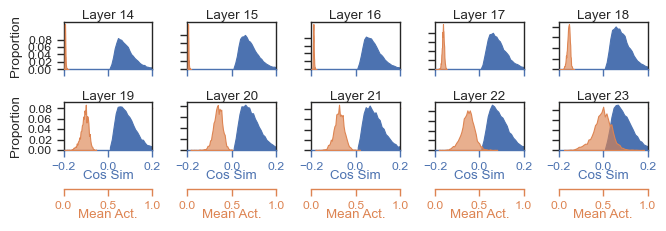

: 

In [ ]:
def plot_latent_act_relations(all_mean_activations, all_bias_scores, selected_layers=None, num_bins=100):
    """
    Produces a multi-panel figure similar to the example:
      - Blue histogram: distribution of bias align for each layer
      - Orange histogram: distribution of Mean Activation for each layer

    all_mean_activations: dict {layer -> np.array(...) of shape (N,)}
    all_cos_sims:         dict {layer -> np.array(...) of shape (d_hidden,)}
    selected_layers:      list of layers to plot
    num_bins:             number of bins for the histogram
    """
    if selected_layers is None:
        sorted_layers = sorted(all_mean_activations.keys())
        if len(sorted_layers) > 10:
            stride = max(1, len(sorted_layers) // 10)
            selected_layers = sorted_layers[::stride]
        else:
            selected_layers = sorted_layers
    
    sns.set_theme(context="paper", style="ticks", rc={"lines.linewidth": 1})
    colors = sns.color_palette()

    num_plots = len(selected_layers)
    num_rows = 2
    num_cols = int(np.ceil(num_plots / 2))
    
    fig = plt.figure(figsize=(6.75, 2.4))
    gs = GridSpec(num_rows, num_cols, figure=fig)
    
    yticks = [0, 0.02, 0.04, 0.06, 0.08]
    
    for idx, layer in enumerate(selected_layers):
        row = idx // num_cols
        col = idx % num_cols
        
        ax = fig.add_subplot(gs[row, col])
        
        # (A) Plot Cos Sim distribution on primary x-axis
        cos_sim_layer = all_bias_scores[layer]
        sns.histplot(
            cos_sim_layer,
            bins=num_bins,
            ax=ax,
            stat="probability",
            color=colors[0],
            alpha=1,
            element="poly",
            label="Cos Sim"
        )
        
        # (B) Plot Mean Activation distribution on a twin x-axis
        ax2 = ax.twiny()
        mean_act_layer = all_mean_activations[layer]
        sns.histplot(
            mean_act_layer,
            bins=num_bins,
            ax=ax2,
            stat="probability",
            color=colors[1],
            alpha=0.65,
            element="poly",
            label="Mean Act."
        )
        
        # Title and basic styling
        ax.set_title(f"Layer {layer}", pad=-10)
        if yticks is not None:
            ax.set(yticks=yticks)
    
        ax.set_xlim([-0.2, 0.2])
        ax.set_xticks([-0.2, 0, 0.2])
        ax.spines["bottom"].set_color(colors[0])
        ax.xaxis.label.set_color(colors[0])
        ax.tick_params(axis="x", colors=colors[0])
        ax.set_xlabel("Cos Sim", labelpad=-1)
        
        # Secondary axis (Mean Act) formatting
        ax2.set_xlim([0, 0.9])
        ax2.set_xticks([0, 0.5, 1])
        
        ax2.xaxis.set_ticks_position("bottom")
        ax2.xaxis.set_label_position("bottom")
        ax2.spines["bottom"].set_position(("outward", 28))
        ax2.set_frame_on(True)
        ax2.patch.set_visible(False)
        for spine in ax2.spines.values():
            spine.set_visible(False)
        ax2.spines["bottom"].set_visible(True)
        
        ax2.spines["bottom"].set_color(colors[1])
        ax2.xaxis.label.set_color(colors[1])
        ax2.tick_params(axis="x", colors=colors[1])
        ax2.set_xlabel("Mean Act.", labelpad=-1)
        
        if col == 0:
            ax.set_ylabel("Proportion")
        else:
            ax.set_yticklabels([])
            ax.set_ylabel(None)
        
        if row == 0:
            ax.xaxis.set_ticklabels([])
            ax.xaxis.label.set_visible(False)
            ax2.xaxis.set_visible(False)
    
    plt.tight_layout()
    plt.show()


selected_layers = list(range(14, 24))

plot_latent_act_relations(
    all_mean_activations=all_mean_activations,
    all_bias_scores=all_bias_scores,
    selected_layers=selected_layers,
    num_bins=50
)